# Understanding Attrition and Engagement
**Goal:** This analysis will use logistic regressiona and random forest to provide insights on:
1. What is driving attrition and who is most likely to leave
2. What is driving employee engagement

**Data:** This analysis uses an HR dataset created by IBM data scientists. The data can be found on Kaggle [here](https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset).

## Import Libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("white")
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all'
pd.set_option('display.max_columns', None)  

#Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier


## Data Preview
We're working with 1470 observations and 35 columns. A review of the data within Kaggle suggests our data is quite clean; but we'll preview the data below.

Initial observations:
* There does not appear to be any missing data or duplicate employee IDs
* All columns appear to have appropriate initial data types
* All numeric columns appear to have reasonable values (no inherently improbably mins/maxs)
* The Attrition column is our first outcome of interest
    * 16% of employees in the dataset turned over (moderate imbalance, unsurprising)
* The Job Satisfaction column is our second outcome of interest
    * mean = 2.7, sd = 1.1
* Other notable attributes:
    * Most employees never travel (71%)
    * Most employees work in R&D (65%) following by Sales (30%)
    * Most employees come from the Life Sciences or Medical fields (73%)
    * 60% of employees are male
    * Mean age = 36.9 years, sd = 9.1
    * Mean tenure = 7.0 years, sd = 6.1

In [2]:
hr_dat = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
hr_dat.shape

(1470, 35)

In [3]:
hr_dat.info()
hr_dat.head()
hr_dat['EmployeeNumber'].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


1470

In [4]:
hr_dat.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


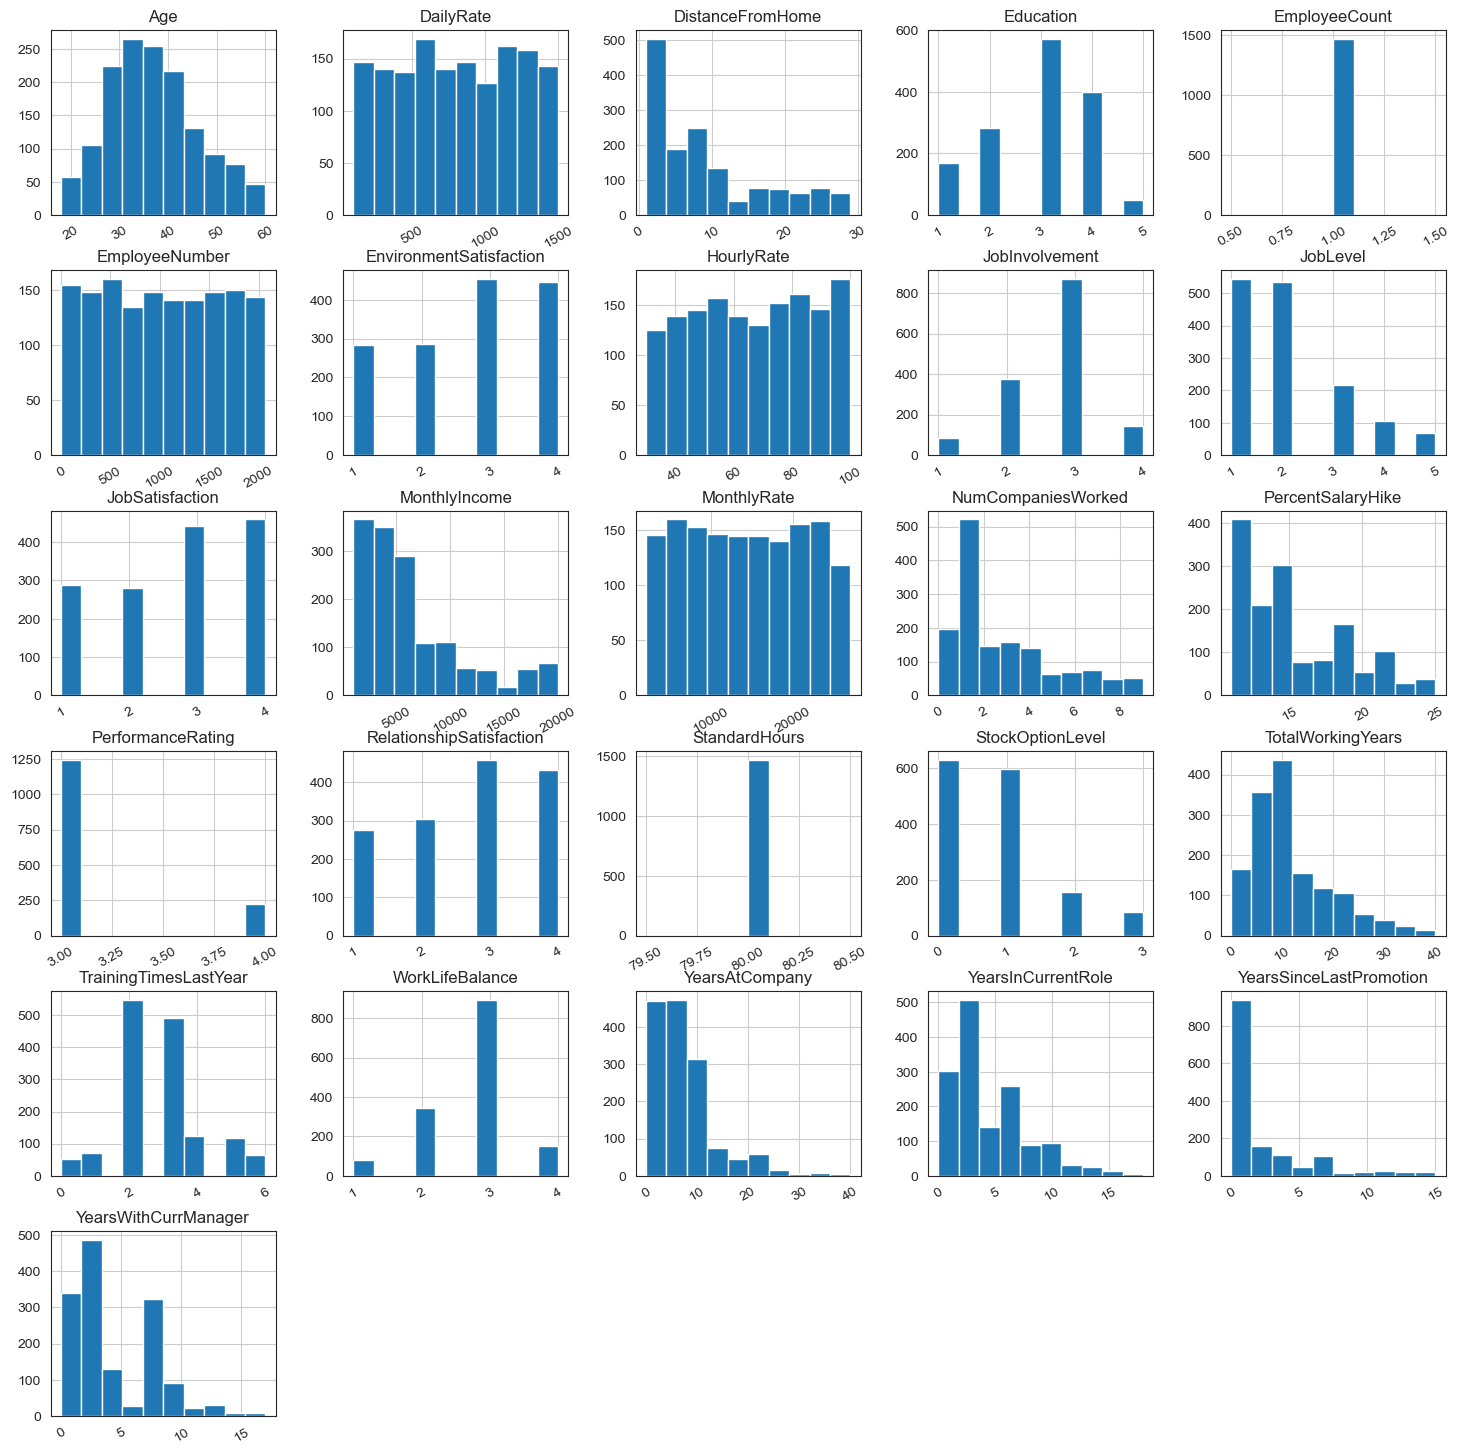

In [5]:
hr_dat.hist(figsize=(18,18), xrot=30)
plt.show();

In [7]:
#review categorical columns
cat_cols = hr_dat.select_dtypes(include=['object']).columns

for c in cat_cols:
    hr_dat[c].value_counts(normalize = True)

No     0.838776
Yes    0.161224
Name: Attrition, dtype: float64

Travel_Rarely        0.709524
Travel_Frequently    0.188435
Non-Travel           0.102041
Name: BusinessTravel, dtype: float64

Research & Development    0.653741
Sales                     0.303401
Human Resources           0.042857
Name: Department, dtype: float64

Life Sciences       0.412245
Medical             0.315646
Marketing           0.108163
Technical Degree    0.089796
Other               0.055782
Human Resources     0.018367
Name: EducationField, dtype: float64

Male      0.6
Female    0.4
Name: Gender, dtype: float64

Sales Executive              0.221769
Research Scientist           0.198639
Laboratory Technician        0.176190
Manufacturing Director       0.098639
Healthcare Representative    0.089116
Manager                      0.069388
Sales Representative         0.056463
Research Director            0.054422
Human Resources              0.035374
Name: JobRole, dtype: float64

Married     0.457823
Single      0.319728
Divorced    0.222449
Name: MaritalStatus, dtype: float64

Y    1.0
Name: Over18, dtype: float64

No     0.717007
Yes    0.282993
Name: OverTime, dtype: float64

From here, we can drop some unnecessary columns:
* EmployeeCount - All 1s
* EmployeeNumber - Unique identifier
* StandardHours - All 80
* Over18 - All Y

In [8]:
hr_clean = hr_dat.drop(columns=['EmployeeCount','EmployeeNumber','StandardHours', 'Over18'], axis=1)

# Analysis 1: Attrition
Let's discover what is driving attrition and what features may best predict attrition.

## Exploratory Data Analysis


In [9]:
#Recode attrition column to 1/0
hr_clean['Attrition'] = hr_clean['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)
hr_clean['Attrition'].value_counts(normalize=True)

0    0.838776
1    0.161224
Name: Attrition, dtype: float64

### Distrubtion of Attrition by Categorical Columns


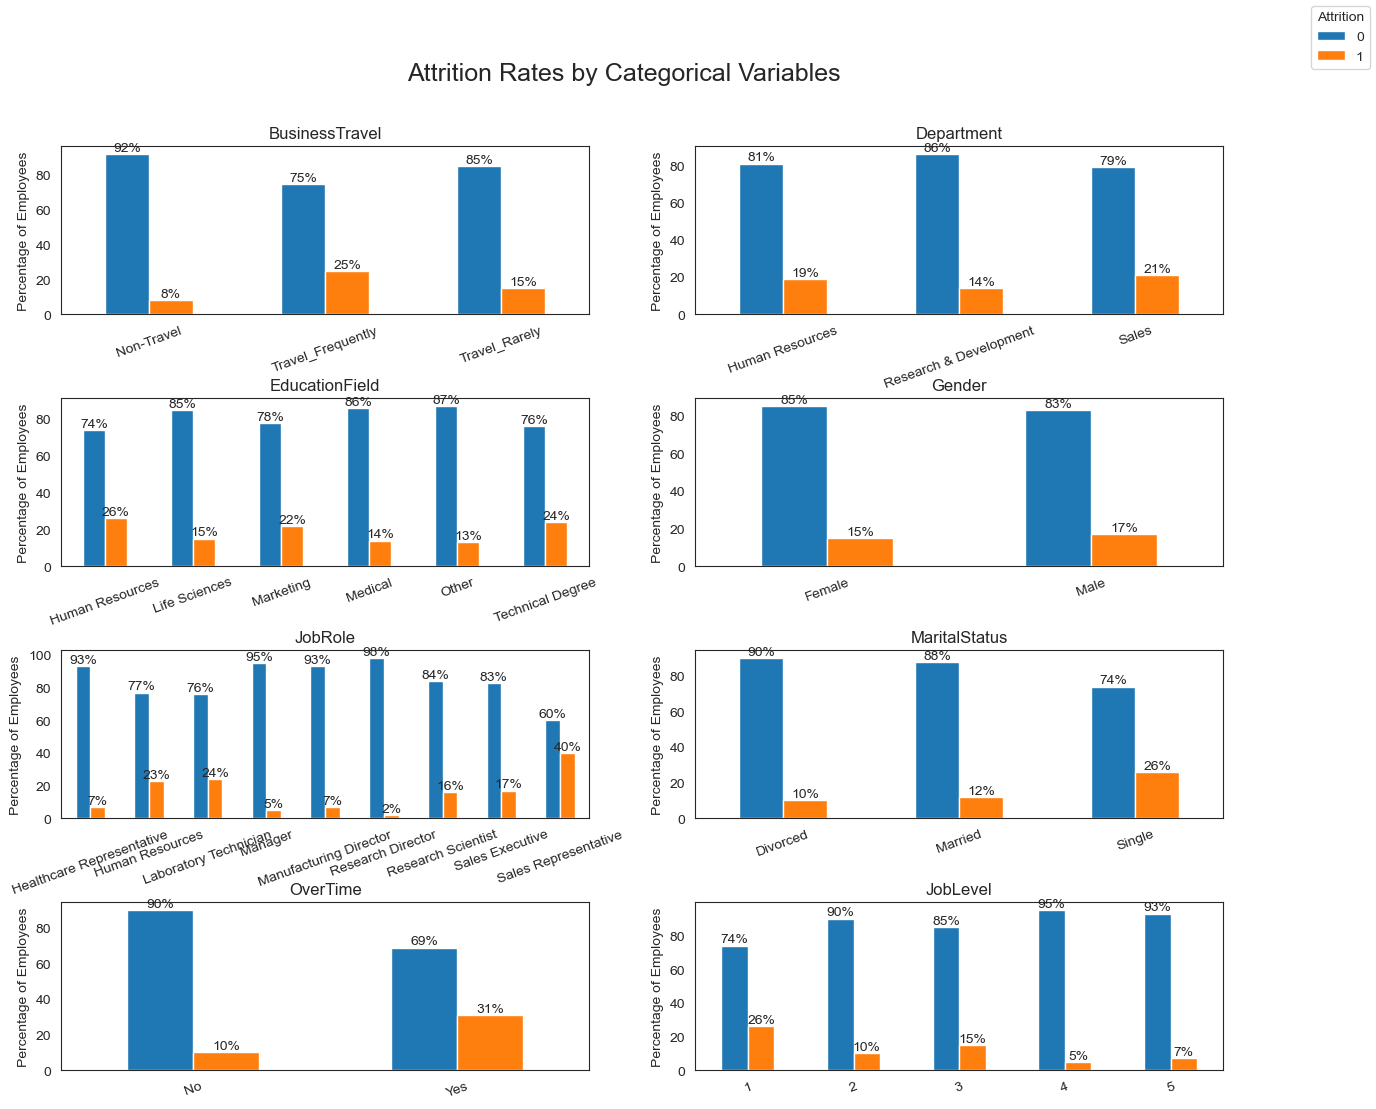

In [10]:
target_cat_cols = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'OverTime', 'JobLevel']

# define subplot grid
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Attrition Rates by Categorical Variables", fontsize=18, y=0.95)
# create empty list to store labels for legend
labels = []

# loop through columns and axes
for col, ax in zip(target_cat_cols, axs.ravel()):
    # filter df for ticker and plot on specified axes
    # Group by variables and get proportions
    grouped_df = hr_clean.groupby([col, 'Attrition']).size().groupby(level=0).apply(lambda x: round(x / x.sum()*100, 0)).reset_index(name='proportion')

    # Pivot table to format data for plotting
    pivot_df = grouped_df.pivot(index= col, columns='Attrition', values='proportion')

    # Plot bar chart
    pivot_df.plot(kind='bar', rot=20, ax=ax)

    # Add value labels to bars
    for p in ax.containers:
        ax.bar_label(p, label_type='edge', labels=[f"{int(round(height))}%" for height in p.datavalues], fontsize=10)

    # Set x and y-axis labels
    ax.set_xlabel('')
    ax.set_ylabel('Percentage of Employees')


    # Append the labels for this subplot to the list
    labels.append(pivot_df.columns.to_list())
    # Remove legend
    ax.legend().set_visible(False)

    # Set the title for the subplot
    ax.set_title(f"{col}")
    ax.grid(False)
    
# Flatten the list of labels and remove duplicates
flat_labels = list(set([item for sublist in labels for item in sublist]))

# Show legend at the top right of the figure
fig.legend(labels=flat_labels, loc='upper right', title='Attrition')

plt.show();

Observations:
* R&D make up the majority of employees, buth they have lower attrition than HR and Sales. This trend is further illustrated when viewing attrition by Job Role and Education Field.
    * Overtime and frequent travel do not vary significantly between departments.
* Attrition is similar for males and females.
* Attrition is heightened for employees working overtime, traveling frequently, for single employees, and entry level employees. 
    * Overtime, travel, and department breakdowns are similar for each marital status.
    * It's possible that single individuals have more flexibility to changes jobs, or perhaps there are other covariates that explain the higher attrition rate that we haven't looked at yet. (ex. correlation with age?)

Takeaways:
* Overtime, Travel, and Department may elicit insights on attrition trends. Marital status is curious, but would take some additional investigation to determine its practical significance.

### Distribution of Attrition by Engagement-Related Metrics

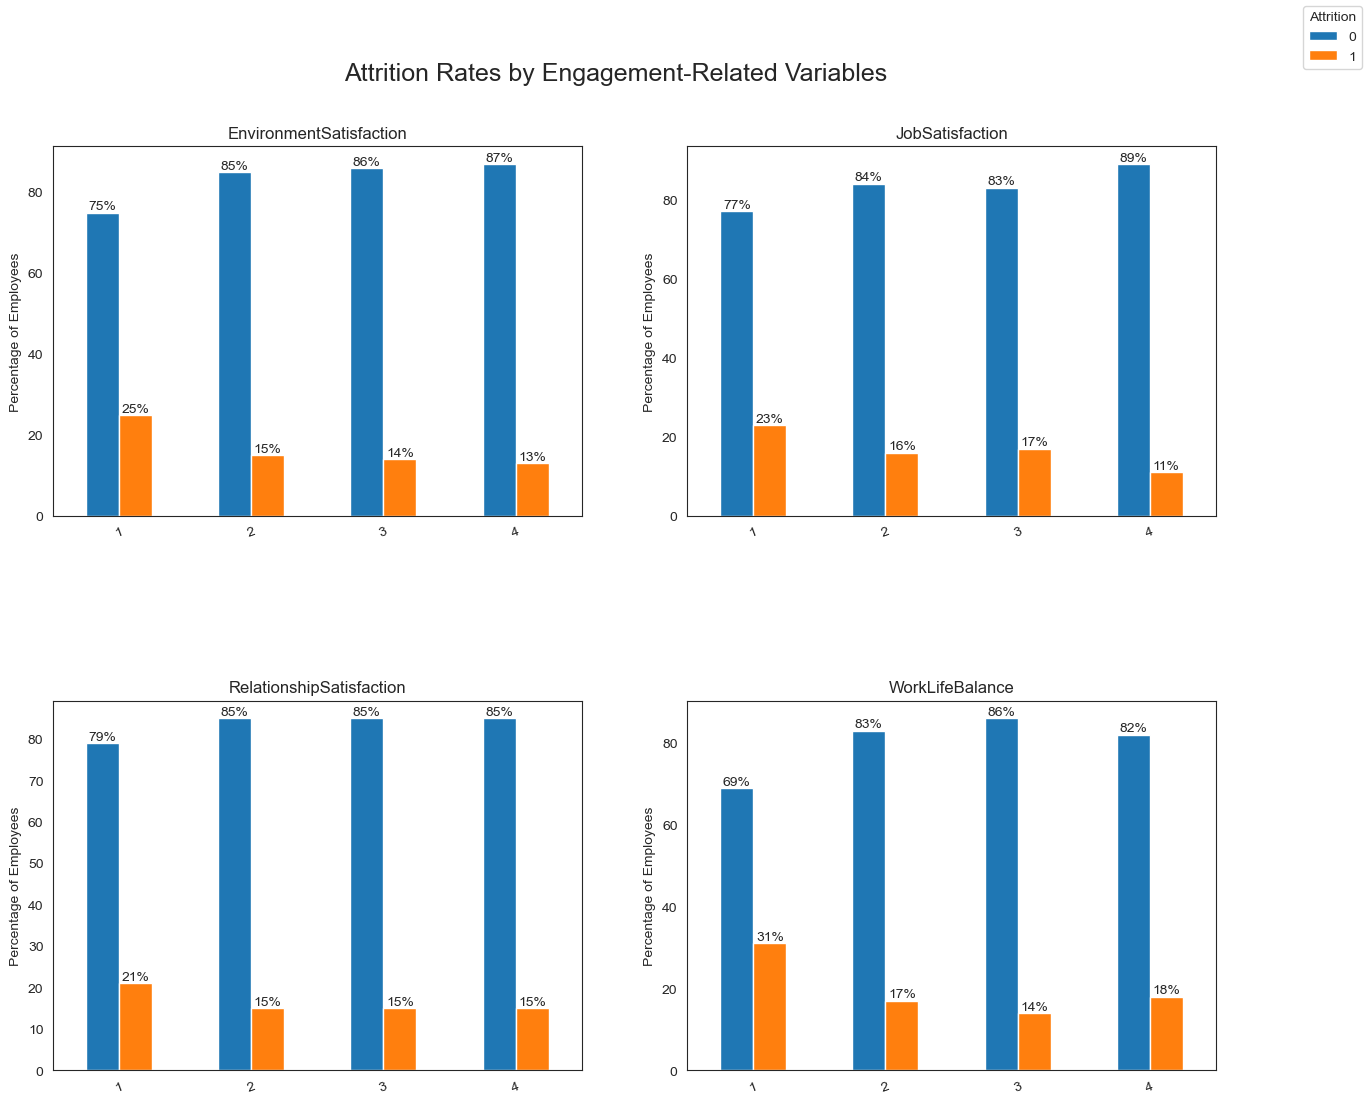

In [11]:
eng_cols = ['EnvironmentSatisfaction', 'JobSatisfaction', 'RelationshipSatisfaction', 'WorkLifeBalance']

# define subplot grid
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Attrition Rates by Engagement-Related Variables", fontsize=18, y=0.95)
# create empty list to store labels for legend
labels = []

# loop through columns and axes
for col, ax in zip(eng_cols, axs.ravel()):
    # filter df for ticker and plot on specified axes
    # Group by variables and get proportions
    grouped_df = hr_clean.groupby([col, 'Attrition']).size().groupby(level=0).apply(lambda x: round(x / x.sum()*100, 0)).reset_index(name='proportion')

    # Pivot table to format data for plotting
    pivot_df = grouped_df.pivot(index= col, columns='Attrition', values='proportion')

    # Plot bar chart
    pivot_df.plot(kind='bar', rot=20, ax=ax)

    # Add value labels to bars
    for p in ax.containers:
        ax.bar_label(p, label_type='edge', labels=[f"{int(round(height))}%" for height in p.datavalues], fontsize=10)

    # Set x and y-axis labels
    ax.set_xlabel('')
    ax.set_ylabel('Percentage of Employees')


    # Append the labels for this subplot to the list
    labels.append(pivot_df.columns.to_list())
    # Remove legend
    ax.legend().set_visible(False)

    # Set the title for the subplot
    ax.set_title(f"{col}")
    ax.grid(False)
    
# Flatten the list of labels and remove duplicates
flat_labels = list(set([item for sublist in labels for item in sublist]))

# Show legend at the top right of the figure
fig.legend(labels=flat_labels, loc='upper right', title='Attrition')

plt.show();

In [33]:
### Engagement Metrics x Job Role

In [12]:
deptEng = hr_clean.groupby(['Department', 'Attrition'])[['JobSatisfaction','WorkLifeBalance','EnvironmentSatisfaction','RelationshipSatisfaction']].mean().reset_index()
deptEng

,Department,Attrition,JobSatisfaction,WorkLifeBalance,EnvironmentSatisfaction,RelationshipSatisfaction
0,Human Resources,0,2.705882,2.921569,2.764706,2.843137
1,Human Resources,1,2.166667,2.916667,2.333333,3.083333
2,Research & Development,0,2.769324,2.748792,2.787440,2.739130
3,Research & Development,1,2.458647,2.578947,2.473684,2.518797
4,Sales,0,2.810734,2.836158,2.734463,2.706215
5,Sales,1,2.521739,2.739130,2.467391,2.652174


### Correlation Matrix


In [13]:
#Transform variables
# map variables with order to numeric
hr_dummies = hr_clean.copy()
hr_dummies['Gender'] = hr_dummies['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
hr_dummies['OverTime'] = hr_dummies['OverTime'].apply(lambda x: 1 if x == 'Yes' else 0)
hr_dummies['BusinessTravel'] = hr_dummies['BusinessTravel'].apply(lambda x: 0 if x == 'Non-Travel' else
                                                                  1 if x == 'Travel_Rarely' else 3 )

#Grab dummies for cat vars of interest
hr_dummies = pd.get_dummies(hr_dummies, columns=['Department', 'MaritalStatus', 'JobRole', 'EducationField'], drop_first=True)

hr_dummies.head()

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Department_Research & Development,Department_Sales,MaritalStatus_Married,MaritalStatus_Single,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree
0,41,1,1,1102,1,2,2,0,94,3,2,4,5993,19479,8,1,11,3,1,0,8,0,1,6,4,0,5,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
1,49,0,3,279,8,1,3,1,61,2,2,2,5130,24907,1,0,23,4,4,1,10,3,3,10,7,1,7,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
2,37,1,1,1373,2,2,4,1,92,2,1,3,2090,2396,6,1,15,3,2,0,7,3,3,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
3,33,0,3,1392,3,4,4,0,56,3,1,3,2909,23159,1,1,11,3,3,0,8,3,3,8,7,3,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
4,27,0,1,591,2,1,1,1,40,3,1,2,3468,16632,9,0,12,3,4,1,6,3,3,2,2,2,2,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0


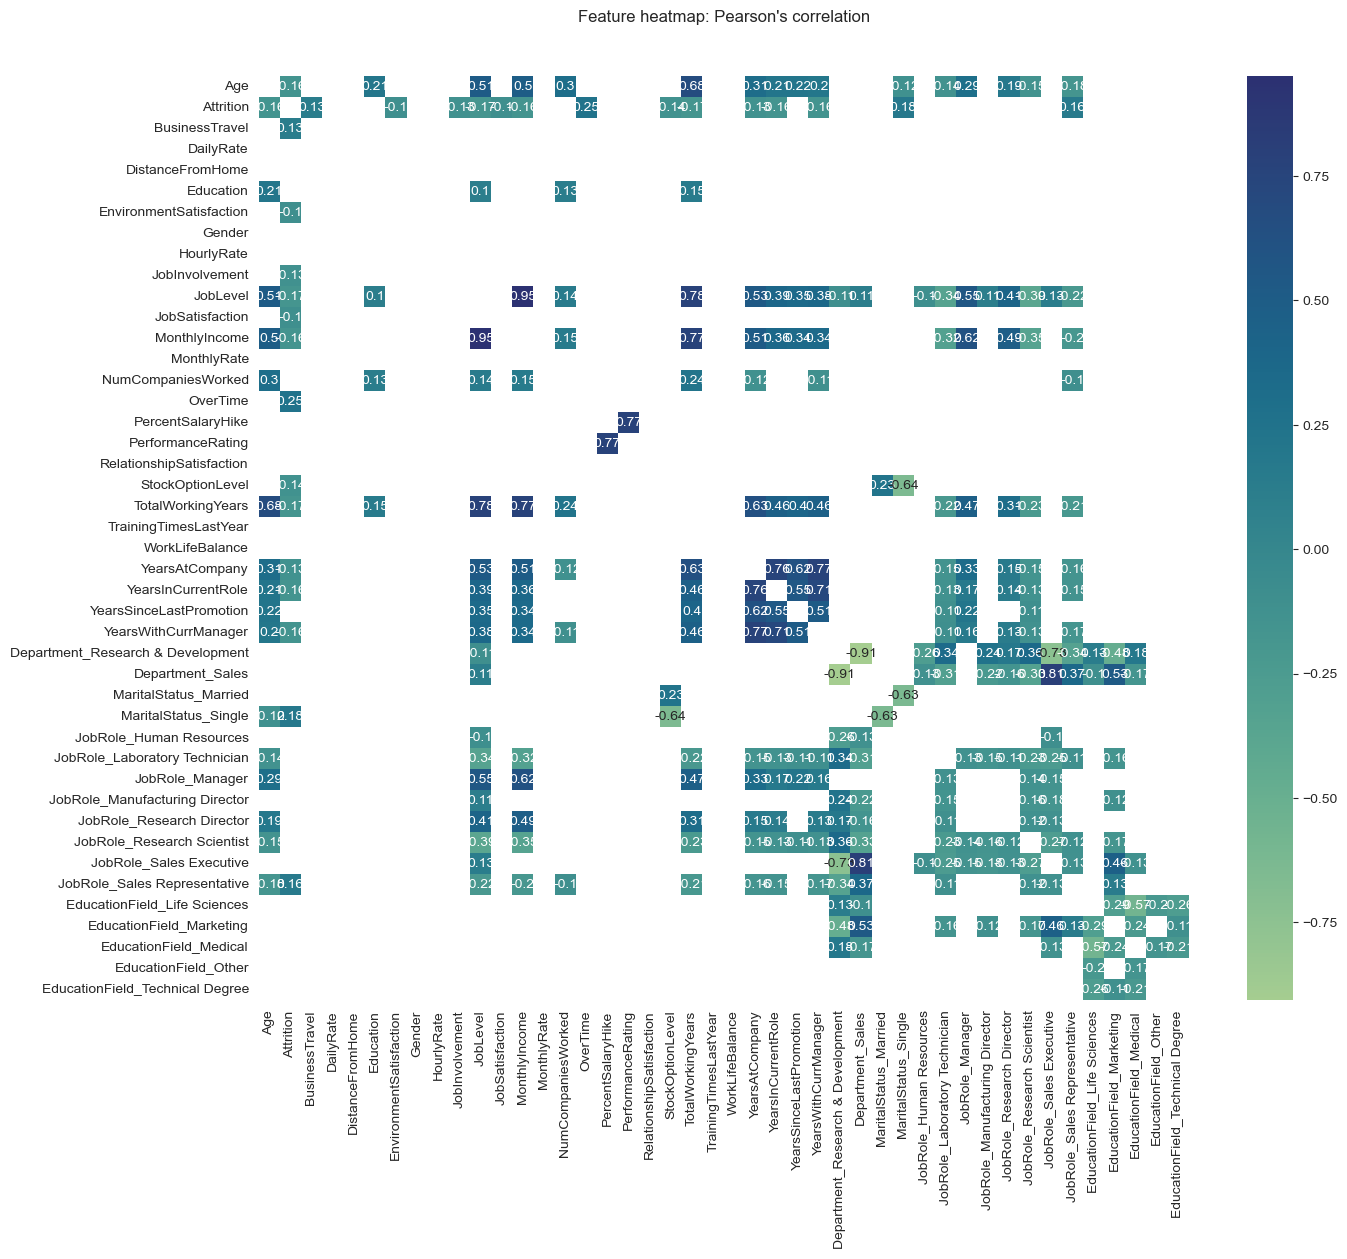

In [14]:
#create pearson correlation heatmap of features
corrs = hr_dummies.corr()

#only show corrs between .2 and 1 for readability (corr = 1 is just self correlation)
plt.figure(figsize=(15,12))
sns.heatmap(corrs[((corrs>0.1)&(corrs<1)) | (corrs < -.1)], cmap='crest', annot=True)
plt.title("Feature heatmap: Pearson's correlation", y = 1.05);

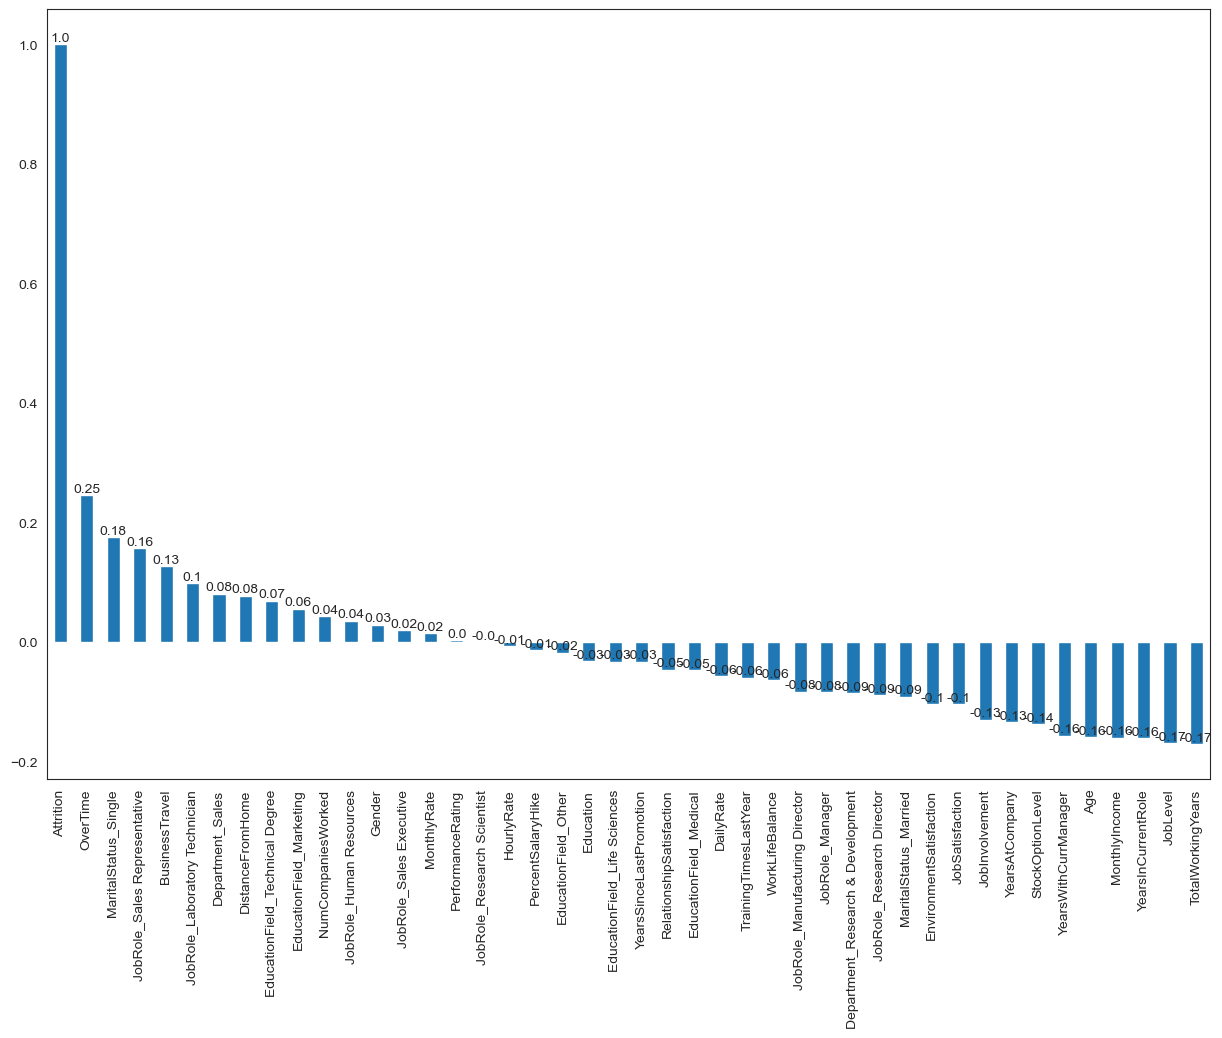

In [41]:
#Let's get a better view of what correlates with attrition
plt.figure(figsize=(15,10))
corplot = corrs['Attrition'].sort_values(ascending = False).plot(kind='bar')
# Add labels to the bars
for i, val in enumerate(corrs['Attrition'].sort_values(ascending=False)):
    corplot.text(i, val, round(val, 2), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontsize': 10})
plt.show();


## Feature Selection
Currently, our model could have up to 47 features! To avoid over-fitting the model, I'd like to reduce this number. Here are my guiding principles:
1. Include job engagement related features - This are can be insightful, actionable, and domain knowledge (research) suggests these may drive attrition. Keep:
* RelationshipSatisfaction
* EnvironmentSatisfaction
* WorkLifeBalance
* JobSatisfaction

2a. Remove features w/ < .05 correlation with attrition. 
2b. Eliminate features that are highly inter-correlated. Inter-correlated features will not add enough incremental uniqueness or value to the model. Through EDA and reviewing inter-correlations, I'll select features I think will be most insightful and strike through the eliminated features.
* OverTime
* MaritalStatusSingle
* BusinessTravel
* JobRoleLabTech
* ~~DepartmentSales~~
* DistanceFromHome
* EducationFieldTechnical.Degree
* EducationFieldMarketing
* ~~TotalWorkingYears~~
* JobLevel
* ~~YearsInCurrentRole~~
* MonthlyIncome
* Age
* ~~YearsWithCurrManager~~
* StockOptionLevel
* YearsAtCompany
* MaritalStatusMarried
* JobRoleResearch.Director
* MaritalStatusDivorced
* ~~DeparmentResearchAndDev~~
* JobRoleManager
* JobRoleManufacturingDirector
* JobRoleHealthcare.Rep
* TrainingTimesLastYear

Final List:
* RelationshipSatisfaction
* EnvironmentSatisfaction
* WorkLifeBalance
* JobSatisfaction
* OverTime
* MaritalStatusSingle
* BusinessTravel
* JobRoleLabTech
* DistanceFromHome
* EducationFieldTechnical.Degree
* EducationFieldMarketing
* JobLevel
* MonthlyIncome
* Age
* StockOptionLevel
* YearsAtCompany
* MaritalStatusMarried
* JobRoleResearch.Director
* JobRoleManager
* JobRoleManufacturingDirector
* TrainingTimesLastYear




In [15]:
hr_final = hr_dummies[['Attrition', 
                       'RelationshipSatisfaction',
                       'EnvironmentSatisfaction',
                       'WorkLifeBalance',
                       'JobSatisfaction',
                       'OverTime',
                       'MaritalStatus_Single',
                       'BusinessTravel',
                       'JobRole_Laboratory Technician',
                       'DistanceFromHome',
                       'EducationField_Technical Degree',
                       'EducationField_Marketing',
                       'JobLevel',
                       'MonthlyIncome',
                       'Age',
                       'StockOptionLevel',
                       'YearsAtCompany',
                       'MaritalStatus_Married',
                       'JobRole_Research Director',
                       'JobRole_Manager',
                       'JobRole_Manufacturing Director',
                       'TrainingTimesLastYear']]

In [16]:
hr_dummies.head()

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Department_Research & Development,Department_Sales,MaritalStatus_Married,MaritalStatus_Single,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree
0,41,1,1,1102,1,2,2,0,94,3,2,4,5993,19479,8,1,11,3,1,0,8,0,1,6,4,0,5,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
1,49,0,3,279,8,1,3,1,61,2,2,2,5130,24907,1,0,23,4,4,1,10,3,3,10,7,1,7,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
2,37,1,1,1373,2,2,4,1,92,2,1,3,2090,2396,6,1,15,3,2,0,7,3,3,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
3,33,0,3,1392,3,4,4,0,56,3,1,3,2909,23159,1,1,11,3,3,0,8,3,3,8,7,3,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
4,27,0,1,591,2,1,1,1,40,3,1,2,3468,16632,9,0,12,3,4,1,6,3,3,2,2,2,2,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0


Let's start with a regression model.
We'll perform an 80/20 split, standardize the features, and then fit the model with an L1 lasso penalty to help reduce model complexity and optimize performance.

In [17]:
hr_final = hr_dummies

# set up training and testing sets
X = hr_final.drop('Attrition', axis = 1)
y = hr_final['Attrition']

#80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size =.2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)


#scale features
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

(1176, 43)
(294, 43)
(1176,)
(294,)


0    0.831633
1    0.168367
Name: Attrition, dtype: float64

0    0.867347
1    0.132653
Name: Attrition, dtype: float64

In [18]:
#create model
att_log_model = LogisticRegression(solver = 'liblinear',
                                   penalty='l1') #Lasso regression to decrease complexity, optimize performance

#fit model on training data
att_log_model.fit(X_train_scale, y_train)

#predict
att_log_pred = att_log_model.predict(X_test_scale)


LogisticRegression(penalty='l1', solver='liblinear')

In [19]:
#Parameters
print(f"Model Intercept (Exponentiated): {np.exp(att_log_model.intercept_)}")

features = pd.DataFrame(X_train.columns)
coeff = pd.DataFrame(np.exp(att_log_model.coef_))
coeff = coeff.melt(var_name ='num', value_name='coeff')

log_odds = pd.concat([features, coeff], axis =1)
log_odds.drop('num', axis = 1, inplace=True)
log_odds = log_odds.sort_values(by = 'coeff', ascending = False)
log_odds


Model Intercept (Exponentiated): [0.07656192]


,0,coeff
14,OverTime,2.597075
31,JobRole_Laboratory Technician,1.977918
29,MaritalStatus_Single,1.804871
22,YearsAtCompany,1.798590
13,NumCompaniesWorked,1.642933
24,YearsSinceLastPromotion,1.609235
1,BusinessTravel,1.512517
37,JobRole_Sales Representative,1.480913
27,Department_Sales,1.375770
30,JobRole_Human Resources,1.368540


,0,1
0,243,12
1,21,18


Specificity: 0.9529411764705882
Sensitivity: 0.46153846153846156


Text(0, 0.5, 'True Pos')

Text(0.5, 0, 'False Pos')

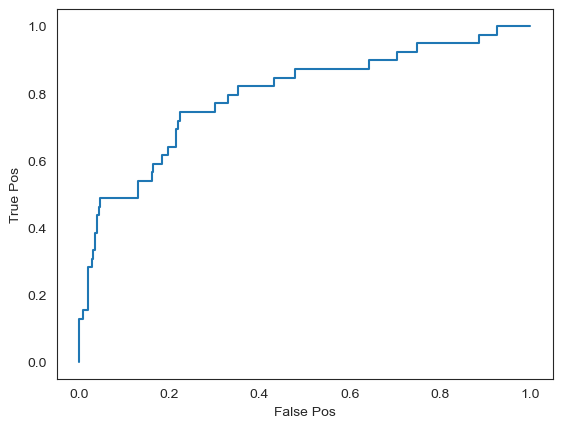

ROC AUC: 0.7072398190045249


,0,1,accuracy,macro avg,weighted avg
precision,0.920455,0.600000,0.887755,0.760227,0.877945
recall,0.952941,0.461538,0.887755,0.707240,0.887755
f1-score,0.936416,0.521739,0.887755,0.729078,0.881408
support,255.000000,39.000000,0.887755,294.000000,294.000000


0.11509409321345247

In [34]:
#Evaluations
pd.DataFrame(confusion_matrix(y_test, att_log_pred))

t_neg, f_pos, f_neg, t_pos = confusion_matrix(y_test, att_log_pred).ravel()

specificity = t_neg / (t_neg+f_pos)
print(f"Specificity: {specificity}")

sensitivity = t_pos / (t_pos + f_neg)
print(f"Sensitivity: {sensitivity}")

#ROC AUC
proba = att_log_model.predict_proba(X_test_scale)[::,1]
fpr, tpr, _ = roc_curve(y_test, proba)
plt.plot(fpr, tpr)
plt.ylabel('True Pos')
plt.xlabel('False Pos')
plt.show()

auc = roc_auc_score(y_test, att_log_pred)
print(f"ROC AUC: {auc}")



pd.DataFrame(classification_report(y_test, att_log_pred, output_dict=True))
# Accuracy of 88%
# Precision:
# - Out of all cases predicted as stayers, 90% were correct
# - Out of all cases predicted as leavers, only 63% were correct
# Recall:
# - Out of all true stayers, 97% were correct
# - Out of all true leavers, only 31% were correct
# F1 = .67

# Overall, model is good at classifying stayers correctly, but not very good as classifying leavers.

#Let's try optimizing for sensitivity
fpr, tpr, thresholds = roc_curve(y_test, proba)
desired_true_pos = .75
desired_index = np.argmax(tpr >= desired_true_pos)

desired_thresh = thresholds[desired_index]
desired_thresh

In [38]:
pred_labels = np.where(proba >= desired_thresh,1,0)


t_pos = sum((pred_labels ==1) & (y_test == 1))
f_neg = sum((pred_labels ==0) & (y_test == 1))
t_neg = sum((pred_labels ==0) & (y_test == 10))
f_pos = sum((pred_labels ==1) & (y_test == 0))

sens = t_pos / (t_pos + f_neg)
spec = t_neg / (t_neg + f_pos)
sens
spec

0.7692307692307693

0.0

This model gives us some insight on what might be driving attrition, but it does not have great predictive value. Here are two options I could consider:
1. Using a resampling technique to balance the data (ex. SMOTE, Random Oversampling, etc.)
2. Try out an ensemble technique

I will go with option two. I am hesitant to use resampling because I do not want to overfit the model and create a training/test set that are not generalizable to the reality at this organization, especially if this model is to be used to aid in hiring strategy.

In [101]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

# define the model with default hyperparameters
model = AdaBoostClassifier()
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
# execute the grid search
grid_result = grid_search.fit(X, y)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.905395 using {'learning_rate': 0.1, 'n_estimators': 500}
0.685725 (0.024731) with: {'learning_rate': 0.0001, 'n_estimators': 10}
0.685725 (0.024731) with: {'learning_rate': 0.0001, 'n_estimators': 50}
0.685725 (0.024731) with: {'learning_rate': 0.0001, 'n_estimators': 100}
0.685725 (0.024731) with: {'learning_rate': 0.0001, 'n_estimators': 500}
0.685725 (0.024731) with: {'learning_rate': 0.001, 'n_estimators': 10}
0.685725 (0.024731) with: {'learning_rate': 0.001, 'n_estimators': 50}
0.685725 (0.024731) with: {'learning_rate': 0.001, 'n_estimators': 100}
0.702081 (0.029730) with: {'learning_rate': 0.001, 'n_estimators': 500}
0.685725 (0.024731) with: {'learning_rate': 0.01, 'n_estimators': 10}
0.702621 (0.030797) with: {'learning_rate': 0.01, 'n_estimators': 50}
0.774800 (0.026409) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.835645 (0.025372) with: {'learning_rate': 0.01, 'n_estimators': 500}
0.768592 (0.031282) with: {'learning_rate': 0.1, 'n_estimators': 10}
0.834426

In [26]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

#scale features
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)


# define the model with default hyperparameters
model = AdaBoostClassifier(base_estimator= LogisticRegression())
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [10, 50, 100]
grid['learning_rate'] = [.01, 0.1, 1.0]
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
# execute the grid search
grid_result = grid_search.fit(X_scale, y)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.881179 using {'learning_rate': 1.0, 'n_estimators': 10}
0.838776 (0.003117) with: {'learning_rate': 0.01, 'n_estimators': 10}
0.838776 (0.003117) with: {'learning_rate': 0.01, 'n_estimators': 50}
0.838776 (0.003117) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.838776 (0.003117) with: {'learning_rate': 0.1, 'n_estimators': 10}
0.856236 (0.009082) with: {'learning_rate': 0.1, 'n_estimators': 50}
0.878458 (0.016546) with: {'learning_rate': 0.1, 'n_estimators': 100}
0.881179 (0.016452) with: {'learning_rate': 1.0, 'n_estimators': 10}
0.875510 (0.020344) with: {'learning_rate': 1.0, 'n_estimators': 50}
0.872336 (0.019135) with: {'learning_rate': 1.0, 'n_estimators': 100}


In [29]:
ada_model = AdaBoostClassifier(learning_rate=1.0, n_estimators=500)

#fit
ada_model.fit(X_train_scale, y_train)

#predict
ada_model_pred = ada_model.predict(X_test_scale)



AdaBoostClassifier(n_estimators=500)

In [30]:
pd.DataFrame(confusion_matrix(y_test, ada_model_pred))

t_neg, f_pos, f_neg, t_pos = confusion_matrix(y_test, ada_model_pred).ravel()

specificity = t_neg / (t_neg+f_pos)
print(f"Specificity: {specificity}")

sensitivity = t_pos / (t_pos + f_neg)
print(f"Sensitivity: {sensitivity}")

#ROC AUC
auc = roc_auc_score(y_test, ada_model_pred)
print(f"ROC AUC: {auc}")

pd.DataFrame(classification_report(y_test, ada_model_pred, output_dict=True))

,0,1
0,234,21
1,23,16


Specificity: 0.9176470588235294
Sensitivity: 0.41025641025641024
ROC AUC: 0.6639517345399698


,0,1,accuracy,macro avg,weighted avg
precision,0.910506,0.432432,0.85034,0.671469,0.847088
recall,0.917647,0.410256,0.85034,0.663952,0.850340
f1-score,0.914062,0.421053,0.85034,0.667558,0.848663
support,255.000000,39.000000,0.85034,294.000000,294.000000


In [97]:
from imblearn.over_sampling import SMOTE
X, y = SMOTE(sampling_strategy=1, random_state = 42).fit_resample(X,y)

#80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size =.2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)


#scale features
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)



(1972, 43)
(494, 43)
(1972,)
(494,)


1    0.501521
0    0.498479
Name: Attrition, dtype: float64

0    0.506073
1    0.493927
Name: Attrition, dtype: float64

In [98]:
att_log_model = LogisticRegression(solver = 'liblinear',
                                   penalty='l1') #Lasso regression to decrease complexity, optimize performance

#fit model on training data
att_log_model.fit(X_train_scale, y_train)

#predict
att_log_pred = att_log_model.predict(X_test_scale)

LogisticRegression(penalty='l1', solver='liblinear')

In [99]:
pd.DataFrame(confusion_matrix(y_test, att_log_pred))

t_neg, f_pos, f_neg, t_pos = confusion_matrix(y_test, att_log_pred).ravel()

specificity = t_neg / (t_neg+f_pos)
print(f"Specificity: {specificity}")

sensitivity = t_pos / (t_pos + f_neg)
print(f"Sensitivity: {sensitivity}")

#ROC AUC
auc = roc_auc_score(y_test, att_log_pred)
print(f"ROC AUC: {auc}")

pd.DataFrame(classification_report(y_test, att_log_pred, output_dict=True))

,0,1
0,233,17
1,28,216


Specificity: 0.932
Sensitivity: 0.8852459016393442
ROC AUC: 0.908622950819672


,0,1,accuracy,macro avg,weighted avg
precision,0.892720,0.927039,0.908907,0.909879,0.909671
recall,0.932000,0.885246,0.908907,0.908623,0.908907
f1-score,0.911937,0.905660,0.908907,0.908799,0.908837
support,250.000000,244.000000,0.908907,494.000000,494.000000


In [6]:
print(f"Model Intercept (Exponentiated): {np.exp(att_log_model.intercept_)}")

features = pd.DataFrame(X_train.columns)
coeff = pd.DataFrame(np.exp(att_log_model.coef_))
coeff = coeff.melt(var_name ='num', value_name='coeff')

log_odds = pd.concat([features, coeff], axis =1)
log_odds.drop('num', axis = 1, inplace=True)
log_odds = log_odds.sort_values(by = 'coeff', ascending = False)
log_odds

NameError: name 'att_log_model' is not defined